# Stacked Physics-Informed Neural Networks (Stacked PINNs) in Neuromancer

This tutorial demonstrates the use of stacked (multi-fidelity) PINNs for solving challenging multiscale differential equations in the Neuromancer library.

<img src="../figs/multifidelity_pinn.png" width="1200">  

Despite the success of physics-informed neural networks, the "vanilla" formulation of PINNs [3] tend to fail to learn the solution of certain dynamical systems. In particular, in the presence of multiple fixed points and/or highly oscillatory, multiscale systems, the learned solution might converge to the trivial solution.

In this notebook, we demonstrate how to solve these classes of problems using Stacked PINNs. This method consists of stacking multifidelity networks [1,2] in a composition manner: starting from a single-fidelity network (Step 0, c.f. figure above), the output is fed into a multifidelity block, consisting of two networks: a linear network (with no activation functions), and a nonlinear network. The nonlinear network takes as input the outputs of Step 0 plus the original inputs. The result of the multifidelity layer is a convex combination of the outputs of linear and nonlinear networks, weighted by a learnable parameter $\alpha$ as shown below:

<img src="../figs/multifidelity_detail.png" width="600">  

In this architecture, the output of each of the stacking layers can be seen as a lower fidelity model for the next layer. This composition process progressively improves the learned solution.

In the example below, we demonstrate the example of a damped pendulum, where the classical formulation of PINNs fail to converge to the correct solution, and we show how the stacked model allows us to solve the problem with higher accuracy.


### References

[1] [Howard, Amanda A., et al. (2023) Stacked networks improve physics-informed training: applications to neural networks and deep operator networks.](https://arxiv.org/abs/2311.06483)

[2] [Heinlein, Alexander, et al. (2023) Multifidelity domain decomposition-based physics-informed neural networks for time-dependent problems.](https://arxiv.org/abs/2401.07888)

[3] [Raissi, M., Perdikaris, P., & Karniadakis, G. E. (2017). Physics informed deep learning (part i): Data-driven solutions of nonlinear partial differential equations.](https://www.sciencedirect.com/science/article/abs/pii/S0021999118307125)


## Install (Colab only)
Skip this step when running locally.

In [10]:
# !pip install "neuromancer[examples] @ git+https://github.com/pnnl/neuromancer.git@master"
# !pip install pyDOE

## Imports

In [19]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from neuromancer.dataset import DictDataset
from neuromancer.modules import blocks
from neuromancer.system import Node
from neuromancer.constraint import variable
from neuromancer.loss import PenaltyLoss
from neuromancer.problem import Problem
from neuromancer.trainer import Trainer
from neuromancer.dynamics.integrators import integrators
import numpy as np

# filter some user warnings from torch broadcast
import warnings
warnings.filterwarnings("ignore")


# Device configuration
device = torch.device('cpu')
torch.manual_seed(42);


## Problem Setup

**The Pendulum Problem** is a fundamental example in classical mechanics, where the equations of motion describe the behavior of a simple pendulum under the influence of gravity and damping. The problem is given by the system of first-order ordinary differential equations:

$$
\frac{ds_1}{dt} = s_2,
$$
$$
\frac{ds_2}{dt} = -\frac{b}{m}s_2 - \frac{g}{L}\sin(s_1).
$$

Here, $s_1$ represents the angular displacement, and $s_2$ represents the angular velocity of the pendulum.

**Initial Conditions:**

The initial conditions are given by:
$$ s_1(0) = 0.5, $$
$$ s_2(0) = 0.5. $$

**Parameters:**

The parameters for this problem are:
- Mass of the pendulum $ m = 1 $ kg,
- Length of the pendulum $ L = 1 $ m,
- Damping coefficient $ b = 0.05 $ kg/s,
- Acceleration due to gravity $ g = 9.81 $ m/s²,
- Total simulation time $ T = 20 $ s.



In [20]:
# Parameters
m = 1.0    # Mass (kg)
L = 1.0    # Length (m)
b = 0.05   # Damping coefficient (kg/s)
g = 9.81   # Acceleration due to gravity (m/s^2)
T = 20.0   # Total simulation time (s)

# Initial conditions
s1_0 = 0.5
s2_0 = 0.5

# Number of collocation points
N_cp = 500

# Time discretization
t = torch.linspace(0, T, N_cp).to(device)

# Initial conditions
ic_t = t[0].unsqueeze(0).unsqueeze(0)
ic_s1 = torch.tensor([s1_0]).unsqueeze(0).to(device)
ic_s2 = torch.tensor([s2_0]).unsqueeze(0).to(device)

# Collocation points
t_train_cp = t[1:].unsqueeze(1)

# Combine initial condition and collocation points for training
t_train = torch.cat((ic_t, t_train_cp)).float().to(device)
s_train = torch.cat((torch.tensor([[s1_0, s2_0]]).to(device), torch.zeros((t_train_cp.shape[0], 2)).to(device)))

t_train.requires_grad_(True)

# Create dataset
train_data = DictDataset({'t': t_train}, name='train')



## Network architecture

In this part, we build two networks: a vanilla PINN, and the stacked PINN.


In [21]:
# Neural net to solve the ODE problem
# Variables in: t; variables out: s (s1, s2)
net_vanilla = blocks.MLP(insize=1, outsize=2, hsizes=[200]*3, nonlin=nn.SiLU).to(device)

net_stacked = blocks.StackedMLP(insize=1, outsize=2, n_stacked_mf_layers= 4, h_sf_size=[100]*3, nonlin=nn.SiLU,
                                 h_nonlinear_sizes=[50]*5, h_linear_sizes=[20,20],
                                 #freeze_epochs=[10000, 20000, 30000, 40000], 
                                 verbose=True).to(device)

# Symbolic wrapper of the neural net
# Inputs: t
# outputs: s (s1, s2)
ode_net_vanilla = Node(net_vanilla, ['t'], ['s'], name='net_vanilla')
ode_net_stacked = Node(net_stacked, ['t'], ['s'], name='net_stacked')


In [22]:
# Symbolic Neuromancer variables
s = variable('s')
s1 = s[:, [0]]  # Angular displacement
s2 = s[:, [1]]  # Angular velocity
t = variable('t')  # Time

# Define the ODE system
ds1_dt = s2
ds2_dt = -(b/m) * s2 - (g/L) * torch.sin(s1)

# Define the PINN form
f_pinn1 = s1.grad(t) - ds1_dt
f_pinn2 = s2.grad(t) - ds2_dt
f_pinn1_grad = f_pinn1.grad(t)
f_pinn2_grad = f_pinn2.grad(t)

# Scaling factors for better convergence
scaling_ic_vanilla = 1.0
scaling_cp_vanilla = 1.0
scaling_ic_stacked = 1.0
scaling_cp_stacked = 10.0

# ODE collocation points loss (MSE)
l_cp1_vanilla = scaling_cp_vanilla * (f_pinn1 == torch.tensor(0.).to(device))^2
l_cp2_vanilla = scaling_cp_vanilla * (f_pinn2 == torch.tensor(0.).to(device))^2

l_cp1_stacked = scaling_cp_stacked * (f_pinn1 == torch.tensor(0.).to(device))^2
l_cp2_stacked = scaling_cp_stacked * (f_pinn2 == torch.tensor(0.).to(device))^2

# Initial condition loss (MSE)
l_ic1_vanilla = scaling_ic_vanilla * (s1[0] - ic_s1 == torch.tensor(0.).to(device))^2
l_ic2_vanilla = scaling_ic_vanilla * (s2[0] - ic_s2 == torch.tensor(0.).to(device))^2
l_ic1_stacked = scaling_ic_stacked * (s1[0] - ic_s1 == torch.tensor(0.).to(device))^2
l_ic2_stacked = scaling_ic_stacked * (s2[0] - ic_s2 == torch.tensor(0.).to(device))^2

# Combined loss
loss_vanilla = PenaltyLoss(objectives=[l_cp1_vanilla, l_cp2_vanilla, l_ic1_vanilla, l_ic2_vanilla], constraints=[])
loss_stacked = PenaltyLoss(objectives=[l_cp1_stacked, l_cp2_stacked, l_ic1_stacked, l_ic2_stacked], constraints=[])

# Construct the PINN optimization problem
problem_vanilla = Problem(nodes=[ode_net_vanilla], loss=loss_vanilla, grad_inference=True)
problem_stacked = Problem(nodes=[ode_net_stacked], loss=loss_stacked, grad_inference=True)

# Optimizer
initial_lr = 1e-3
optimizer_vanilla = torch.optim.AdamW(problem_vanilla.parameters(), lr=initial_lr)
optimizer_stacked = torch.optim.AdamW(problem_stacked.parameters(), lr=initial_lr)


In [23]:
# Print parameter counts
print(f" Total number of parameters in single-fidelity net= {sum(p.numel() for p in net_vanilla.parameters())}")
print(f" Total number of parameters in multi-fidelity net= {sum(p.numel() for p in net_stacked.parameters())}")


 Total number of parameters in single-fidelity net= 81202
 Total number of parameters in multi-fidelity net= 64702


In [24]:
# Print vanilla net
print(net_vanilla)

MLP(
  (nonlin): ModuleList(
    (0-2): 3 x SiLU()
    (3): Identity()
  )
  (linear): ModuleList(
    (0): Linear(
      (linear): Linear(in_features=1, out_features=200, bias=True)
    )
    (1-2): 2 x Linear(
      (linear): Linear(in_features=200, out_features=200, bias=True)
    )
    (3): Linear(
      (linear): Linear(in_features=200, out_features=2, bias=True)
    )
  )
)


In [25]:
# Print stacked net
print(net_stacked)

StackedMLP(
  (alpha): ParameterList(
      (0): Parameter containing: [torch.float32 of size ]
      (1): Parameter containing: [torch.float32 of size ]
      (2): Parameter containing: [torch.float32 of size ]
      (3): Parameter containing: [torch.float32 of size ]
  )
  (first_layer): MLP(
    (nonlin): ModuleList(
      (0-2): 3 x SiLU()
      (3): Identity()
    )
    (linear): ModuleList(
      (0): Linear(
        (linear): Linear(
          (linear): Linear(in_features=1, out_features=100, bias=True)
        )
      )
      (1-2): 2 x Linear(
        (linear): Linear(
          (linear): Linear(in_features=100, out_features=100, bias=True)
        )
      )
      (3): Linear(
        (linear): Linear(
          (linear): Linear(in_features=100, out_features=2, bias=True)
        )
      )
    )
  )
  (layers): ModuleList(
    (0-3): 4 x ModuleDict(
      (linear): MLP(
        (nonlin): ModuleList(
          (0-2): 3 x Identity()
        )
        (linear): ModuleList(
      

## Train networks

### Train "vanilla" net

In [26]:
# Number of epochs
epochs_vanilla = 50001

# Neuromancer trainer
trainer_vanilla = Trainer(
    problem_vanilla.to(device),
    torch.utils.data.DataLoader(train_data, batch_size=t_train.shape[0],
                                collate_fn=train_data.collate_fn, shuffle=False),
    optimizer=optimizer_vanilla,
    epochs=epochs_vanilla,
    epoch_verbose=5000,
    train_metric='train_loss',
    dev_metric='train_loss',
    eval_metric="train_loss",
    warmup=epochs_vanilla,
    device=device
)

# Train PINN
best_model_vanilla = trainer_vanilla.train()

# Load best trained model
problem_vanilla.load_state_dict(best_model_vanilla)


epoch: 0  train_loss: 18.41791343688965
epoch: 5000  train_loss: 0.006505195051431656
epoch: 10000  train_loss: 0.00511967483907938
epoch: 15000  train_loss: 0.004092948045581579
epoch: 20000  train_loss: 0.004740165080875158
epoch: 25000  train_loss: 0.003175815800204873
epoch: 30000  train_loss: 0.0030456329695880413
epoch: 35000  train_loss: 0.002559319604188204
epoch: 40000  train_loss: 0.0025621061213314533
epoch: 45000  train_loss: 0.0023774011060595512
epoch: 50000  train_loss: 0.002386349719017744


<All keys matched successfully>

### Train stacked net

In [27]:
# Number of epochs
epochs_stacked = 50001

# Neuromancer trainer 
trainer_stacked = Trainer(
    problem_stacked.to(device),
    torch.utils.data.DataLoader(train_data, batch_size=t_train.shape[0],
                                collate_fn=train_data.collate_fn, shuffle=False),
    optimizer=optimizer_stacked,
    epochs=epochs_stacked,
    epoch_verbose=5000,
    train_metric='train_loss',
    dev_metric='train_loss',
    eval_metric="train_loss",
    warmup=epochs_stacked,
    device=device,
    multi_fidelity=True
)

# Train PINN
best_model_stacked = trainer_stacked.train()

# Load best trained model
problem_stacked.load_state_dict(best_model_stacked)


epoch: 0  train_loss: 25.321632385253906
epoch: 5000  train_loss: 0.0363730862736702
epoch: 10000  train_loss: 0.02877199277281761
epoch: 15000  train_loss: 0.023000376299023628
epoch: 20000  train_loss: 0.02121264487504959
epoch: 25000  train_loss: 0.01926872879266739
epoch: 30000  train_loss: 0.018717575818300247
epoch: 35000  train_loss: 0.017837664112448692
epoch: 40000  train_loss: 0.016061697155237198
epoch: 45000  train_loss: 0.01489781029522419
epoch: 50000  train_loss: 0.014973273500800133


<All keys matched successfully>

## Results

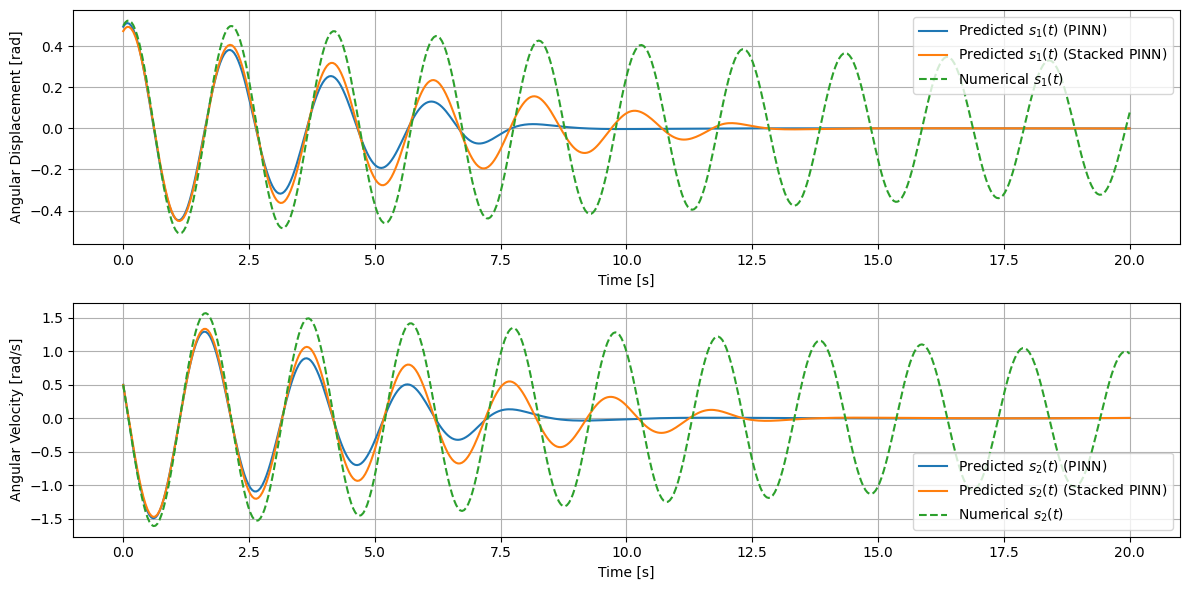

In [28]:
# Visualize results

# Single-fidelity predictions
s_pred_vanilla = ode_net_vanilla(train_data.datadict)['s'].detach().cpu().numpy()
s1_pred_vanilla = s_pred_vanilla[:, 0]
s2_pred_vanilla = s_pred_vanilla[:, 1]
t_train = train_data.datadict['t'].detach().cpu().numpy()

# Multi-fidelity predictions
s_pred_stacked = ode_net_stacked(train_data.datadict)['s'].detach().cpu().numpy()
s1_pred_stacked = s_pred_stacked[:, 0]
s2_pred_stacked = s_pred_stacked[:, 1]

# Solve the ODE numerically in Neuromancer using 4th order Runge-Kutta
class PendulumODE(nn.Module):
    def __init__(self, b, m, g, L, insize=2, outsize=2):
        super().__init__()
        self.b = b
        self.m = m
        self.g = g
        self.L = L
        self.in_features = insize
        self.out_features = outsize

    def forward(self, x, t=None):
        s1 = x[:, [0]]
        s2 = x[:, [1]]
        ds1_dt = s2
        ds2_dt = -self.b / self.m * s2 - self.g / self.L * torch.sin(s1)
        return torch.cat([ds1_dt, ds2_dt], dim=-1)

pendulum_ode = PendulumODE(b, m, g, L)
fxRK4 = integrators['RK4'](pendulum_ode, h=T/N_cp)
y0 = torch.tensor([[s1_0, s2_0]])
t_eval = torch.linspace(0, T, N_cp)

# Solve the ODE numerically using RK4 integrator
y_t = y0
sol = [y_t]
for t in t_eval[1:]:
    y_t = fxRK4(y_t)
    sol.append(y_t)
sol = torch.stack(sol).detach().numpy()


# Plot the results
plt.figure(figsize=(12, 6))

# Angular Displacement
plt.subplot(2, 1, 1)
plt.plot(t_train, s1_pred_vanilla, label='Predicted $s_1(t)$ (PINN)')
plt.plot(t_train, s1_pred_stacked, label='Predicted $s_1(t)$ (Stacked PINN)')
plt.plot(t_eval, sol[:,0,0], label='Numerical $s_1(t)$', linestyle='dashed')
plt.xlabel('Time [s]')
plt.ylabel('Angular Displacement [rad]')
plt.legend()
plt.grid(True)

# Angular Velocity
plt.subplot(2, 1, 2)
plt.plot(t_train, s2_pred_vanilla, label='Predicted $s_2(t)$ (PINN)')
plt.plot(t_train, s2_pred_stacked, label='Predicted $s_2(t)$ (Stacked PINN)')
plt.plot(t_eval, sol[:,0,1], label='Numerical $s_2(t)$', linestyle='dashed')
plt.xlabel('Time [s]')
plt.ylabel('Angular Velocity [rad/s]')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [29]:
# Verify that final parameter alpha is small (see Eq. 11 of Howard, Amanda A. et al. 2023).
for idx,alpha in enumerate(net_stacked.alpha):
    print(f"alpha_{idx} = {alpha}")


alpha_0 = Parameter containing:
tensor(0.0002, requires_grad=True)
alpha_1 = Parameter containing:
tensor(0.0408, requires_grad=True)
alpha_2 = Parameter containing:
tensor(0.0550, requires_grad=True)
alpha_3 = Parameter containing:
tensor(0.1466, requires_grad=True)
